In [1]:
!pip install --upgrade pip
print(1)
!pip install --quiet -U "torch>=1.8.1"
print(2)
!pip install --quiet -U "setuptools>=67.0"
print(3)
!pip install --quiet -U "torchmetrics>=0.7"
print(4)
!pip install --quiet -U "torchvision"
print(5)
!pip install --quiet -U "pytorch-lightning>=1.4"
print(6)
!pip install --quiet -U "lightning"
print(7)
!pip uninstall -y nvidia_cublas_cu11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
1
2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
librosa 0.10.0 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
distributed 2021.11.2 requires dask==2021.11.2, but yo

In [2]:
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html
# print(1)
# !git clone https://github.com/NVIDIA/apex
# %cd apex
# !pip install -v --disable-pip-version-check --no-cache-dir ./
# print(2)
# !mkdir /tmp/cudnn && cd /tmp/cudnn
# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/libcudnn8_8.0.5.39-1+cuda11.1_amd64.deb
# !sudo dpkg -i libcudnn8_8.0.5.39-1+cuda11.1_amd64.deb
# print(3)
# !pip install cupy
# print(4)
# !pip install mxnet-cuXX

In [3]:
# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
# !sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
# !wget https://developer.download.nvidia.com/compute/cuda/12.1.0/local_installers/cuda-repo-ubuntu2204-12-1-local_12.1.0-530.30.02-1_amd64.deb
# !sudo dpkg -i cuda-repo-ubuntu2204-12-1-local_12.1.0-530.30.02-1_amd64.deb
# !sudo cp /var/cuda-repo-ubuntu2204-12-1-local/cuda-*-keyring.gpg /usr/share/keyrings/
# !sudo apt-get update
# !sudo apt-get -y install cuda

```
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torch import nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torch.utils.tensorboard import SummaryWriter
import pickle

import numpy as np
import math
from PIL import Image
import glob
from datetime import datetime
import os
import torch.nn.functional as F

In [5]:
image_size=360

In [6]:
class GANDataset(Dataset):
    def __init__(self,
                root_dir="../input/dogs-cats-images/dataset/training_set/cats", 
                transform=transforms.Compose([
                        transforms.Resize((image_size, image_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5])
                ])
        ):
        self.file_list = glob.glob(os.path.join(root_dir, '*.jpg'))
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = self.transform(img)
        return img
    
class GANDataloader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, num_workers=0):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=self.collate_fn)
        
    def collate_fn(self, batch):
        # Convert a batch of images to a tensor
        return torch.stack(batch, dim=0)

In [7]:
dataset = GANDataset()

dataloader = GANDataloader(dataset, batch_size=64, shuffle=True, num_workers=2)


# for batch in dataloader:
#     print(batch.size())
    
sample = dataset[0]
print(sample.size())

torch.Size([3, 360, 360])


In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size=100, hidden_size=256, image_size=360):
        super().__init__()
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.image_size = image_size
        self.generator = nn.Sequential(
            nn.Linear(self.latent_size, self.hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_size, self.image_size * self.image_size * 3),
            nn.Tanh()
        )

    def forward(self, z):
        fake_images = self.generator(z.view(-1, self.latent_size))
        fake_images = fake_images.view(-1, 3, self.image_size, self.image_size)
        return fake_images


class Discriminator(nn.Module):
    def __init__(self, hidden_size=256, image_size=360):
        super().__init__()
        self.hidden_size = hidden_size
        self.image_size = image_size
        self.discriminator = nn.Sequential(
            nn.Linear(self.image_size * self.image_size * 3, self.hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, images):
        images = images.view(-1, 3, self.image_size, self.image_size)
        images = F.interpolate(images, size=(self.image_size, self.image_size), mode='nearest')
        outputs = self.discriminator(images.view(images.size(0), -1))
        return outputs

In [9]:
class GAN(nn.Module):
    def __init__(self, dataset,
                 batch_size=128,
                 latent_size=100,
                 hidden_size=256,
                 image_size=360,
                 num_epochs=50,
                 lr=0.0002,
                 beta1=0.5,
                 serialization_path=None,
                 deserialization_path='/kaggle/working/checkpoint.pt'):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.image_size = image_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.beta1 = beta1
        self.checkpoint_interval = 5

        self.dataset = dataset
        if torch.cuda.is_available():
            self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True)
        else:
            self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

        self.generator = Generator(self.latent_size, self.hidden_size, self.image_size).to(self.device)
        self.discriminator = Discriminator(self.hidden_size, self.image_size).to(self.device)

        self.criterion = nn.BCELoss().to(self.device)
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))

        self.serialization_path = serialization_path
        if serialization_path:
            with open(serialization_path, 'rb') as f:
                self.serialization_data = pickle.load(f)
                self.load_state_dict(self.serialization_data['model_state_dict'])
                self.generator_optimizer.load_state_dict(self.serialization_data['optimizer_G_state_dict'])
                self.discriminator_optimizer.load_state_dict(self.serialization_data['optimizer_D_state_dict'])
        
        self.deserialization_path = deserialization_path
        self.writer = SummaryWriter(log_dir='logs/' + datetime.now().strftime("%Y%m%d-%H%M%S"))
        self.current_iteration = 0

    def train(self):
        for epoch in range(self.num_epochs):
            for i, data in enumerate(self.dataloader):
                real_images = data[0].to(self.device)

                # Train discriminator with real images
                self.discriminator_optimizer.zero_grad()
                real_labels = torch.ones(1, 1).to(self.device) # real_images.size(0)
                real_outputs = self.discriminator(real_images)
                d_loss_real = self.criterion(real_outputs, real_labels)
                d_loss_real.backward()

                # Train discriminator with fake images
                z = torch.randn(real_images.size(0), self.latent_size).to(self.device)
                fake_images = self.generator(z)
                fake_labels = torch.zeros(real_images.size(0), 1).to(self.device)
                fake_outputs = self.discriminator(fake_images.detach())
                d_loss_fake = self.criterion(fake_outputs, fake_labels)
                d_loss_fake.backward()
                # Update discriminator parameters
                d_loss = d_loss_real + d_loss_fake
                self.discriminator_optimizer.step()

                # Train generator
                self.generator_optimizer.zero_grad()
                fake_labels.fill_(1)
                outputs = self.discriminator(fake_images)
                g_loss = self.criterion(outputs, fake_labels)
                g_loss.backward()

                # Update generator parameters
                self.generator_optimizer.step()

                # Print losses and save sample images
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\t'
                          'Discriminator Loss: %.4f\t'
                          'Generator Loss: %.4f' %
                          (epoch+1, self.num_epochs, i+1, len(self.dataloader),
                           d_loss.item(), g_loss.item()))

                    # Save sample images
                    if not os.path.exists('samples'):
                        os.makedirs('samples')
                    if self.current_iteration % 100 == 0:
                        with torch.no_grad():
                            sample_images = self.generator(torch.randn(16, self.latent_size).to(self.device))
                            save_image(sample_images, f'samples/{self.current_iteration}.png', nrow=4)

                    # Write loss values to TensorBoard
                    self.writer.add_scalar('Loss/Discriminator', d_loss.item(), self.current_iteration)
                    self.writer.add_scalar('Loss/Generator', g_loss.item(), self.current_iteration)

                    self.current_iteration += 1

                # Save model and optimizer states every 5 iterations
                if self.deserialization_path and epoch % 5 == 0:
                    self.deserialization_data = {
                        'model_state_dict': self.state_dict(),
                        'optimizer_G_state_dict': self.generator_optimizer.state_dict(),
                        'optimizer_D_state_dict': self.discriminator_optimizer.state_dict(),
                    }
                    torch.save(self.deserialization_data, self.deserialization_path)

            # Save final model and optimizer states
            if self.deserialization_path:
                self.deserialization_data = {
                    'model_state_dict': self.state_dict(),
                    'optimizer_G_state_dict': self.generator_optimizer.state_dict(),
                    'optimizer_D_state_dict': self.discriminator_optimizer.state_dict(),
                }
                torch.save(self.deserialization_data, self.deserialization_path)
    
    
    def train_transfer(self, serialization_path="/kaggle/working/checkpoint.pt", deserialization_path="", percentage_used_layers=None):
        # Load the pre-trained weights
        checkpoint = torch.load(serialization_path, map_location=self.device)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.generator_optimizer.load_state_dict(checkpoint['optimizer_G_state_dict'])
        self.discriminator_optimizer.load_state_dict(checkpoint['optimizer_D_state_dict'])

        # Freeze layers
        n_layers_discriminator = len(self.discriminator.discriminator)
        n_layers_generator = len(self.generator.generator)

        if percentage_used_layers is not None:
            percentage_used_layers = max(0, min(1, percentage_used_layers))
            n_used_layers_discriminator = int(n_layers_discriminator * percentage_used_layers)
            n_used_layers_generator = int(n_layers_generator * percentage_used_layers)
        else:
            n_used_layers_discriminator = 1
            n_used_layers_generator = 1

        for (name_disc, param_disc), i_disc in zip(self.discriminator.named_parameters(), range(n_layers_discriminator)):
            if name_disc.startswith('discriminator') and param_disc.requires_grad:
                param_disc.requires_grad = i_disc >= n_layers_discriminator - n_used_layers_discriminator

        for (name_gen, param_gen), i_gen in zip(self.generator.named_parameters(), range(n_layers_generator)):
            if name_gen.startswith('generator') and param_gen.requires_grad:
                param_gen.requires_grad = i_gen >= n_layers_generator - n_used_layers_generator

        # Resume training
        for epoch in range(self.num_epochs):
            for i, data in enumerate(self.dataloader):
                real_images = data[0].to(self.device)

                # Train discriminator with real images
                self.discriminator_optimizer.zero_grad()
                real_labels = torch.ones(1, 1, device=self.device) # real_images.size(0)
                real_outputs = self.discriminator(real_images)
                d_loss_real = self.criterion(real_outputs, real_labels)
                d_loss_real.backward(retain_graph=True)

                # Train discriminator with fake images
                z = torch.randn(real_images.size(0), self.latent_size).to(self.device)
                fake_images = self.generator(z)
                fake_labels = torch.zeros(real_images.size(0), 1, device=self.device, requires_grad=False)
                fake_outputs = self.discriminator(fake_images)
                d_loss_fake = self.criterion(fake_outputs, fake_labels)
                d_loss_fake.backward(retain_graph=True)
                # Update discriminator parameters
                d_loss = d_loss_real + d_loss_fake
                self.discriminator_optimizer.step()

                # Train generator
                self.generator_optimizer.zero_grad()
                fake_labels.fill_(1)
                fake_outputs = self.discriminator(fake_images)
                g_loss = self.criterion(fake_outputs, fake_labels)
                g_loss.backward(retain_graph=True)
                # Update generator parameters
                self.generator_optimizer.step()

                # Log losses to Tensorboard
                self.writer.add_scalar('Discriminator Loss', d_loss.item(), self.current_iteration)
                self.writer.add_scalar('Generator Loss', g_loss.item(), self.current_iteration)
                self.current_iteration += 1
                # Print losses and save sample images
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\t'
                          'Discriminator Loss: %.4f\t'
                          'Generator Loss: %.4f' %
                          (epoch+1, self.num_epochs, i+1, len(self.dataloader),
                           d_loss.item(), g_loss.item()))
                # Save sample images
                if not os.path.exists('samples'):
                    os.makedirs('samples')
                if self.current_iteration % 100 == 0:
                    with torch.no_grad():
                        sample_images = self.generator(torch.randn(self.batch_size, self.latent_size).to(self.device))
                        self.writer.add_images('Generated Images', sample_images, self.current_iteration)
                        vutils.save_image(sample_images, 'samples/epoch%d_batch%d.png' % (epoch+1, i+1), nrow=8, normalize=True)

            # Save checkpoint
            if self.checkpoint_interval > 0 and (epoch + 1) % self.checkpoint_interval == 0:
                torch.save({
                    'model_state_dict': self.state_dict(),
                    'optimizer_G_state_dict': self.generator_optimizer.state_dict(),
                    'optimizer_D_state_dict': self.discriminator_optimizer.state_dict(),
                }, 'checkpoint.pt')

        # Save final model
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_G_state_dict': self.generator_optimizer.state_dict(),
            'optimizer_D_state_dict': self.discriminator_optimizer.state_dict(),
        }, 'final.pt')
    
    def generate_noise(self, n_samples):
        return torch.randn(n_samples, self.latent_size, 1, 1, device=self.device)

    def generate_fake_images(self, n_samples=10, save_folder_path=''):
        with torch.no_grad():
            self.generator.eval()
            z = self.generate_noise(n_samples)
            fake_images = self.generator(z)
            for i in range(n_samples):
                vutils.save_image(fake_images[i].detach(), os.path.join(save_folder_path, f'fake_image_{i}.png'), normalize=True)

    def test(self, n_samples):
        with torch.no_grad():
            self.generator.eval()
            z = self.generate_noise(n_samples).view(n_samples, self.latent_size, 1, 1)
            fake_images = self.generator(z).detach().cpu()
        return fake_images

    def visualize_generation(self, fake_images_path=""):
        # Load generated images from file
        fake_images = []
        i = 0
        while True:
            img_path = os.path.join(fake_images_path, f"fake_image_{i}.png")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                fake_images.append(img)
                i += 1
            else:
                break
        num_images = len(fake_images)
        # Resize to target size of dataset
        transform = transforms.Compose([
            transforms.Resize((360, 360)),
            transforms.ToTensor(),
        ])
        fake_images = [transform(img) for img in fake_images]
        # Add a new dimension to the tensor
        fake_images = torch.stack(fake_images, dim=0).unsqueeze(1)
        print(fake_images.size())
        # Calculate image grid shape
        rows = int(math.sqrt(num_images))
        cols = math.ceil(num_images / rows)
        # Visualize generated images
        fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
        fig.suptitle(f"Generated Images ({num_images} total)")
        axs = np.ravel(axs) # modify this line
        for i, ax in enumerate(axs):
            if i < num_images:
                ax.imshow(fake_images[i].permute(0, 2, 3, 1)[0])
                ax.axis('off')
                ax.set_title(f"Image {i+1}")
            else:
                ax.axis('off')
        plt.show()

In [10]:
gan = GAN(batch_size=512, dataset=GANDataset(), latent_size=100, hidden_size=256, num_epochs=25, lr=0.0002, beta1=0.5)

In [11]:
gan.train()

[1/25][1/8]	Discriminator Loss: 1.4181	Generator Loss: 2.0636
[2/25][1/8]	Discriminator Loss: 3.8075	Generator Loss: 2.1739
[3/25][1/8]	Discriminator Loss: 0.1365	Generator Loss: 2.6470
[4/25][1/8]	Discriminator Loss: 0.1280	Generator Loss: 3.6328
[5/25][1/8]	Discriminator Loss: 6.6680	Generator Loss: 1.0154
[6/25][1/8]	Discriminator Loss: 6.5310	Generator Loss: 0.7448
[7/25][1/8]	Discriminator Loss: 0.5736	Generator Loss: 1.6238
[8/25][1/8]	Discriminator Loss: 1.6813	Generator Loss: 1.2318
[10/25][1/8]	Discriminator Loss: 0.7348	Generator Loss: 1.5624
[11/25][1/8]	Discriminator Loss: 6.6171	Generator Loss: 0.0098
[13/25][1/8]	Discriminator Loss: 1.1851	Generator Loss: 1.2731
[14/25][1/8]	Discriminator Loss: 3.1651	Generator Loss: 0.2017
[17/25][1/8]	Discriminator Loss: 0.4469	Generator Loss: 1.5628
[18/25][1/8]	Discriminator Loss: 0.5236	Generator Loss: 1.4555
[19/25][1/8]	Discriminator Loss: 0.7347	Generator Loss: 1.6033
[20/25][1/8]	Discriminator Loss: 6.7795	Generator Loss: 0.0285


In [12]:
gan.device

device(type='cuda')

In [13]:
# fake_images = Image.open(os.path.join('/kaggle/working/', 'fake_image_0.png'))
# fake_images.size

In [14]:
gan.train_transfer()

[1/25][1/8]	Discriminator Loss: 1.7858	Generator Loss: 0.4210
[2/25][1/8]	Discriminator Loss: 4.3108	Generator Loss: 0.0147
[3/25][1/8]	Discriminator Loss: 3.2031	Generator Loss: 0.0417
[4/25][1/8]	Discriminator Loss: 2.8700	Generator Loss: 0.0656
[5/25][1/8]	Discriminator Loss: 2.1739	Generator Loss: 0.1574
[6/25][1/8]	Discriminator Loss: 4.2645	Generator Loss: 0.0184
[7/25][1/8]	Discriminator Loss: 3.6813	Generator Loss: 0.0309
[8/25][1/8]	Discriminator Loss: 4.3928	Generator Loss: 0.0441
[9/25][1/8]	Discriminator Loss: 4.3894	Generator Loss: 0.0174
[10/25][1/8]	Discriminator Loss: 4.0508	Generator Loss: 0.0177
[11/25][1/8]	Discriminator Loss: 3.5242	Generator Loss: 0.0467
[12/25][1/8]	Discriminator Loss: 5.2091	Generator Loss: 0.0073
[13/25][1/8]	Discriminator Loss: 4.0117	Generator Loss: 0.0246
[14/25][1/8]	Discriminator Loss: 5.8172	Generator Loss: 0.0051
[15/25][1/8]	Discriminator Loss: 4.1211	Generator Loss: 0.0429
[16/25][1/8]	Discriminator Loss: 12.2541	Generator Loss: 0.0262


torch.Size([4, 1, 3, 360, 360])


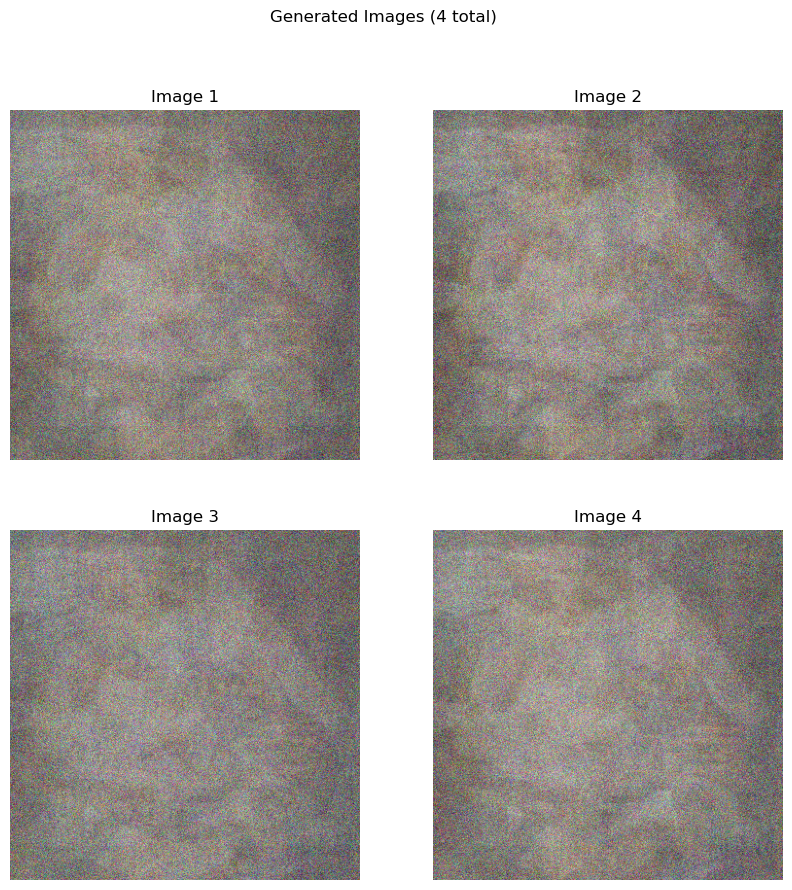

In [15]:
gan.generate_fake_images(4)
# Generate sample images
gan.visualize_generation()

In [16]:
fake_images = gan.test(1)
save_image(fake_images, '/kaggle/working/fake_image.png', normalize=True)

torch.Size([1, 360, 360, 3])


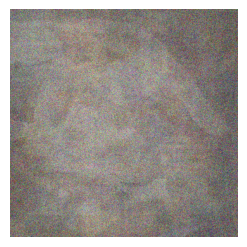

In [17]:
# Load generated images from file
fake_images = Image.open(os.path.join('/kaggle/working/', 'fake_image.png'))

# Resize to target size of dataset
transform = transforms.Compose([
    transforms.Resize((360, 360)),
    transforms.ToTensor(),
])
fake_images = transform(fake_images)

# Add a new dimension to the tensor
fake_images = fake_images.unsqueeze(1)
fake_images = fake_images.permute(1, 2, 3, 0)
print(fake_images.size())

# Visualize generated images
plt.figure(figsize=(10, 10))
for i in range(fake_images.shape[0]):
    plt.subplot(1, 3, i+1)
    plt.imshow(fake_images[i])
    plt.axis('off')
plt.show()

In [18]:
fake_images = []
fake_images_path = "/kaggle/working"
print(os.listdir(fake_images_path))
for file_name in os.listdir(fake_images_path):
    if file_name.endswith('.png'):
        image = Image.open(os.path.join(fake_images_path, file_name))
        fake_images.append(transforms.ToTensor()(image))
fake_images = torch.stack(fake_images, dim=0)

['fake_image_1.png', '.virtual_documents', 'fake_image_2.png', '__notebook_source__.ipynb', 'fake_image.png', 'fake_image_0.png', 'fake_image_3.png', 'checkpoint.pt', 'samples', 'logs', 'final.pt']


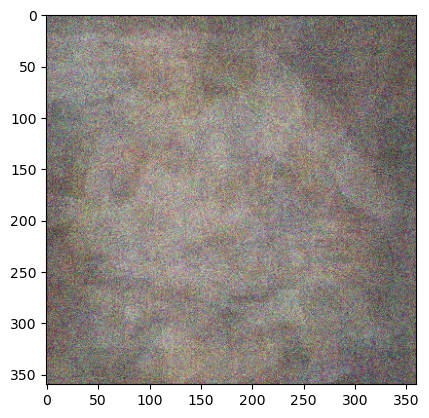

In [19]:
# # Visualize generated images
# plt.figure(figsize=(1, fake_images.shape[0]))
# for i in range(fake_images.shape[0]):
#     plt.subplot(fake_images.shape[0], 1, i+1)
#     plt.imshow(fake_images[i].permute(1, 2, 0))
#     plt.axis('off')
# plt.show()
# reshape the image to (height, width)
# transpose the image to (height, width, channels)
image = np.transpose(fake_images[0], (1, 2, 0))

# display the image
plt.imshow(image)
plt.show()

In [20]:
!sudo apt-get install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [21]:
!zip -r checkpoint.zip checkpoint.pkl

	zip warning: name not matched: checkpoint.pkl

zip error: Nothing to do! (try: zip -r checkpoint.zip . -i checkpoint.pkl)


In [22]:
import os
os.chdir(r'/kaggle/working')

#!tar -czf Landscapes.tar.gz images_out/Landscapes

from IPython.display import FileLink

FileLink(r'checkpoint.pkl')

/kaggle/working/checkpoint.pkl

In [23]:
# import os

# # Set the directory path to kaggle/input
# data_dir = "../input/imagenet/imagenet/val"

# # Get all the folders in the directory
# folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# # Print the list of folders
# print(folders)

In [24]:
# import os
# from PIL import Image

# # Set the directory path to the images
# data_dir = "../input/imagenet/imagenet/val"

# # Get a list of all the image files in the directory
# image_files = [f for f in os.listdir(data_dir) if f.endswith('.JPEG')]

# # Loop through each image file and get its size
# image_sizes = []
# for image_file in image_files:
#     # Open the image using PIL.Image
#     image_path = os.path.join(data_dir, image_file)
#     with Image.open(image_path) as img:
#         # Get the size of the image and append it to the list
#         image_sizes.append(img.size)

# # Print the list of image sizes

# # print(image_sizes)

#### **Import needed packages**

In [25]:
# import os

# import lightning as L
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, random_split, Dataset
# from typing import List

# PATH_DATASETS = "../input/imagenet/imagenet"
# BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# NUM_WORKERS = int(os.cpu_count() / 2)

#### **Create class for dataloader**

In [26]:
# class ImageNetDataset(Dataset):
#     def __init__(self, data_dir: str, transform: transforms.Compose):
#         self.image_dir = data_dir
#         self.transform = transform
#         self.img_list = os.listdir(self.image_dir)
    
#     def __len__(self):
#         return len(self.img_list)
    
#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_dir, self.img_list[idx])
        
#         with open(label_path, "r") as f:
#             label = int(f.read())
        
#         image = Image.open(img_path).convert("RGB")
#         image = self.transform(image)
        
#         return image

# class ImageNetDataModule(L.LightningDataModule):
#     def __init__(self, data_dir: str=PATH_DATASETS, batch_size: int = 32):
#         super().__init__()
#         self.data_dir = data_dir
#         self.batch_size = batch_size
#         self.dims = (1, 360, 360)

#     def setup(self, stage=None):
#         transform = transforms.Compose([
#             transforms.Resize(360),
#             transforms.RandomCrop(224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])
        
#         self.train_dataset = ImageNetDataset(os.path.join(self.data_dir, "train"), transform)
#         self.val_dataset = ImageNetDataset(os.path.join(self.data_dir, "val"), transform)

#     def train_dataloader(self):
#         return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

#     def val_dataloader(self):
#         return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

#### **Define block for styleGAN2**

In [27]:
# class AdaIN(nn.Module):
#     def __init__(self, eps=1e-8):
#         super().__init__()
#         self.eps = eps
    
#     def forward(self, x, style):
#         # Compute mean and variance of x
#         mean = x.mean(dim=[2, 3], keepdim=True)
#         var = x.var(dim=[2, 3], keepdim=True) + self.eps
        
#         # Compute normalized x
#         x_normalized = (x - mean) / torch.sqrt(var)
        
#         # Reshape style and scale/shift parameters for compatibility with x
#         style = style.view(style.size(0), style.size(1), 1, 1)
#         scale = style[:, :x.size(1), :, :]
#         shift = style[:, x.size(1):, :, :]
        
#         # Apply scale and shift to normalized x
#         x_affine = x_normalized * scale + shift
        
#         return x_affine

In [28]:
# class PixelNorm(nn.Module):
#     def __init__(self, eps=1e-8):
#         super(PixelNorm, self).__init__()
#         self.eps = eps
        
#     def forward(self, x):
#         return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.eps)

In [29]:
# class Reshape(nn.Module):
#     def __init__(self, target_shape):
#         super(Reshape, self).__init__()
#         self.target_shape = target_shape

#     def forward(self, x):
#         return x.view(*self.target_shape)

#### **Define Generator class**

In [30]:
# class Generator(nn.Module):
#     def __init__(self, latent_dim, img_shape):
#         super().__init__()
#         self.img_shape = img_shape
#         self.model = nn.Sequential(
#                         nn.Linear(latent_dim, 4 * 4 * 512),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         nn.BatchNorm2d(512),
#                         PixelNorm(),
#                         Reshape((-1, 512, 4, 4)),
#                         nn.Conv2d(512, 512, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Upsample(scale_factor=2),
#                         nn.Conv2d(512, 256, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Upsample(scale_factor=2),
#                         nn.Conv2d(256, 128, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Upsample(scale_factor=2),
#                         nn.Conv2d(128, 64, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Upsample(scale_factor=2),
#                         # Apply adaptive instance normalization to the feature maps
#                         AdaIN(),
#                         nn.Conv2d(64, 3, 1),
#                         nn.Tanh(),
#                         nn.Upsample(scale_factor=2) # increase output resolution to 360p
#         )
#     def forward(self, z):
#         z = z.view(z.size(0), z.size(1), 1, 1)
#         z = self.model[0](z)
#         z = z.view(z.size(0), 512, 4, 4)
#         img = self.model[1:](z)
#         return img 

#### **Write Descriminator class**

In [31]:
# class Discriminator(nn.Module):
#     def __init__(self, img_shape):
#         super().__init__()
#         self.img_shape = img_shape

#         self.model = nn.Sequential(
#                         nn.Conv2d(3, 64, 1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         nn.Conv2d(64, 128, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Conv2d(128, 256, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Conv2d(256, 512, 3, padding=1),
#                         nn.LeakyReLU(0.2, inplace=True),
#                         PixelNorm(),
#                         nn.Conv2d(512, 1, 4),
#                         nn.Flatten(),
#         )

#     def forward(self, img):
#         img_flat = img.view(img.size(0), *self.img_shape)
#         validity = self.model(img_flat)

#         return validity

#### **Create GAN class where define training loop**

In [32]:
# class GAN(L.LightningModule):
#     def __init__(
#         self,
#         channels,
#         width,
#         height,
#         latent_dim: int = 100,
#         lr: float = 0.0002,
#         b1: float = 0.5,
#         b2: float = 0.999,
#         batch_size: int = BATCH_SIZE,
#         **kwargs,
#     ):
#         super().__init__()
#         self.save_hyperparameters()
#         self.automatic_optimization = False

#         # networks
#         data_shape = (channels, width, height)
#         self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=data_shape)
#         self.discriminator = Discriminator(img_shape=data_shape)

#         self.validation_z = torch.randn(8, self.hparams.latent_dim)

#         self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

#     def forward(self, z):
#         return self.generator(z)

#     def adversarial_loss(self, y_hat, y):
#         return F.binary_cross_entropy(y_hat, y)

#     def training_step(self, batch):
#         imgs, _ = batch

#         optimizer_g, optimizer_d = self.optimizers()

#         # sample noise
#         z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
#         z = z.type_as(imgs)

#         # train generator
#         # generate images
#         self.toggle_optimizer(optimizer_g)
#         self.generated_imgs = self(z)

#         # log sampled images
#         sample_imgs = self.generated_imgs[:6]
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image("generated_images", grid, 0)

#         # ground truth result (ie: all fake)
#         # put on GPU because we created this tensor inside training_loop
#         valid = torch.ones(imgs.size(0), 1)
#         valid = valid.type_as(imgs)

#         # adversarial loss is binary cross-entropy
#         g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
#         self.log("g_loss", g_loss, prog_bar=True)
#         self.manual_backward(g_loss)
#         optimizer_g.step()
#         optimizer_g.zero_grad()
#         self.untoggle_optimizer(optimizer_g)

#         # train discriminator
#         # Measure discriminator's ability to classify real from generated samples
#         self.toggle_optimizer(optimizer_d)

#         # how well can it label as real?
#         valid = torch.ones(imgs.size(0), 1)
#         valid = valid.type_as(imgs)

#         real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

#         # how well can it label as fake?
#         fake = torch.zeros(imgs.size(0), 1)
#         fake = fake.type_as(imgs)

#         fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

#         # discriminator loss is the average of these
#         d_loss = (real_loss + fake_loss) / 2
#         self.log("d_loss", d_loss, prog_bar=True)
#         self.manual_backward(d_loss)
#         optimizer_d.step()
#         optimizer_d.zero_grad()
#         self.untoggle_optimizer(optimizer_d)

#     def configure_optimizers(self):
#         lr = self.hparams.lr
#         b1 = self.hparams.b1
#         b2 = self.hparams.b2

#         opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
#         opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
#         return [opt_g, opt_d], []

#     def on_validation_epoch_end(self):
#         z = self.validation_z.type_as(self.generator.model[0].weight)

#         # log sampled images
#         sample_imgs = self(z)
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

#### **Start train loop**

In [33]:
# dm = ImageNetDataModule()
# model = GAN(*dm.dims)
# trainer = L.Trainer(
#     accelerator="auto",
#     devices=1,
#     max_epochs=5,
# )
# trainer.fit(model, dm)

#### **Enable tensorboard**

In [43]:
# Start tensorboard.
# %load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
# %tensorboard --logdir logs/ --port 6013 --bind_all --load_fast=false